#### In this notebook, features are created and selected for scaling. These are the features that will be the input of a predictive model

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_parquet("../data/processed/cleaned_clv_data.parquet")

In [34]:
df.head()

,customer_id,transaction_count,promo_usage_count,quantity,avg_order_value,first_purchase_date,last_purchase_date,recency,customer_tenure,payment_method_count,total_spent,future_spend,purchase_recency
0,3,12,11,25,963979.761905,2021-01-10 07:56:00,2021-12-12 12:35:00,1682687155506000,355.669249,2,20243575.0,2998828.0,19.475546
1,8,5,1,9,539546.833333,2021-02-13 09:47:00,2021-12-14 20:12:00,1482440343009000,321.591902,2,3237281.0,1521320.0,17.157874
2,9,3,0,5,641399.000000,2021-06-27 01:51:00,2021-11-08 04:42:00,4648648578966000,187.922356,2,3206995.0,906635.0,53.803803
3,15,1,1,1,127423.000000,2021-06-12 04:30:00,2021-06-12 04:30:00,17522957894960000,202.812013,1,127423.0,73320.0,202.812013
4,18,7,11,16,913910.714286,2021-02-01 17:46:00,2021-11-29 19:50:00,2779741989711000,333.259514,2,12794750.0,1980302.0,32.172940


__We'll take transaction recency only in days, it's easier for our model__

__We'll convert from Indonesian Rupiah to US dollars for better currency clarity and widely accepted format__

In [35]:
CONVERSION_RATE = 16787.54   # This is the rate as of January 30 2026, can change ofc

df["total_spent"] = (df["total_spent"] / CONVERSION_RATE).round(3)
df["future_spend"] = (df["future_spend"] / CONVERSION_RATE).round(3)
df["avg_order_value"] = (df["avg_order_value"] / CONVERSION_RATE).round(3)


__So we'll do the distribution of future spend values(log transformed to remove outlier effect while keeping 0 spend customers)__

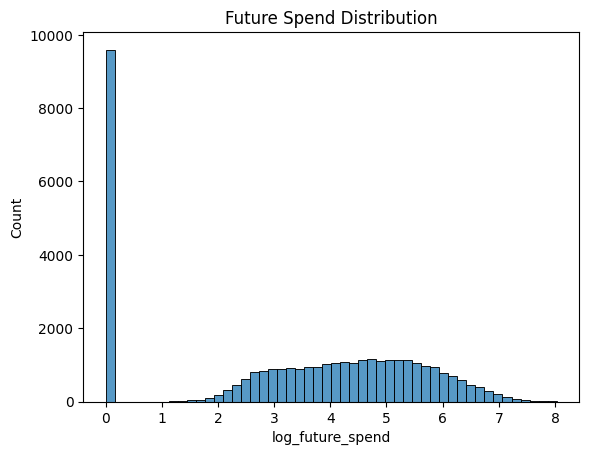

In [36]:
df["log_future_spend"] = np.log1p(df["future_spend"])

plt.figure()
sns.histplot(df["log_future_spend"], bins=50)
plt.title("Future Spend Distribution")
plt.show()

__Grouping buyers and non-buyers based on average transaction activity__
+ Future buyers are more active for promo deals and spend/buy more items
+ Average Gap in purchase recency is about 100 days

In [37]:
df["will_spend"] = (df["future_spend"] > 0 ).astype(int)

df.groupby("will_spend")[[
    "transaction_count",
    "total_spent",
    "avg_order_value",
    "purchase_recency",
    "customer_tenure",
    "promo_usage_count"
]].mean()

,transaction_count,total_spent,avg_order_value,purchase_recency,customer_tenure,promo_usage_count
will_spend,,,,,,
0,1.281322,135.372706,34.662405,147.227677,212.488900,0.695643
1,8.789257,916.456833,49.059931,44.065657,280.433519,4.651329


On average:
+ future spenders make about 8x more transactions
+ And have more recent orders (like 100 days more recent) than those that didn't spend later on

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36086 entries, 0 to 36085
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   customer_id           36086 non-null  int64         
 1   transaction_count     36086 non-null  int64         
 2   promo_usage_count     36086 non-null  int64         
 3   quantity              36086 non-null  int64         
 4   avg_order_value       36086 non-null  float64       
 5   first_purchase_date   36086 non-null  datetime64[ns]
 6   last_purchase_date    36086 non-null  datetime64[ns]
 7   recency               36086 non-null  int64         
 8   customer_tenure       36086 non-null  float64       
 9   payment_method_count  36086 non-null  int64         
 10  total_spent           36086 non-null  float64       
 11  future_spend          36086 non-null  float64       
 12  purchase_recency      36086 non-null  float64       
 13  log_future_spend

In [39]:
df.describe()

,customer_id,transaction_count,promo_usage_count,quantity,avg_order_value,first_purchase_date,last_purchase_date,recency,customer_tenure,payment_method_count,total_spent,future_spend,purchase_recency,log_future_spend,will_spend
count,36086.000000,36086.000000,36086.000000,36086.000000,36086.000000,36086,36086,3.608600e+04,36086.000000,36086.000000,36086.000000,36086.000000,36086.000000,36086.000000,36086.000000
mean,49763.463476,6.793161,3.599651,14.783545,45.232135,2021-04-13 15:07:31.117330944,2021-10-21 12:09:50.795322112,6.176979e+15,262.369431,1.887546,708.793996,135.517851,71.492815,3.293113,0.734135
min,3.000000,1.000000,0.000000,1.000000,1.635000,2021-01-01 00:03:00,2021-01-01 01:14:00,1.647146e+10,0.036409,1.000000,1.635000,0.000000,0.000191,0.000000,0.000000
25%,24718.750000,1.000000,0.000000,2.000000,17.049000,2021-01-21 02:02:45,2021-09-21 01:25:30,1.083406e+15,186.603420,1.000000,33.018000,0.000000,12.539417,0.000000,0.000000
50%,49669.500000,3.000000,1.000000,6.000000,27.521000,2021-03-06 14:58:00,2021-11-24 21:40:00,3.205172e+15,300.376099,1.000000,130.647500,42.775000,37.096903,3.779063,1.000000
75%,74789.750000,8.000000,4.000000,18.000000,51.549750,2021-06-28 09:30:30,2021-12-19 11:03:00,8.807663e+15,344.914339,2.000000,576.420000,167.486250,101.940542,5.126854,1.000000
max,99998.000000,160.000000,101.000000,427.000000,937.057000,2021-12-31 23:07:00,2021-12-31 23:59:00,3.153155e+16,364.997431,5.000000,52428.261000,3069.269000,364.948454,8.029520,1.000000
std,28962.699742,9.341450,6.059360,21.798400,53.532256,NaN,NaN,7.080343e+15,97.963790,1.119340,1759.728243,227.197064,81.948419,2.261950,0.441799


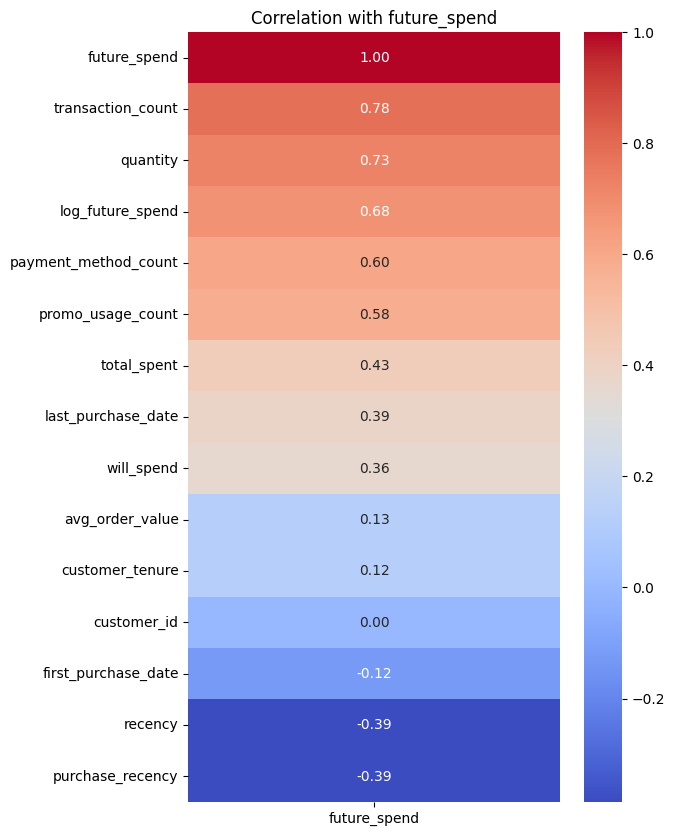

In [40]:

plt.figure(figsize=(6, 10))
sns.heatmap(df.corr()[['future_spend']].sort_values(by='future_spend', ascending=False), 
            annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation with future_spend')
plt.show()

__We'll keep the features that our model will be making use of an drop everything else__
+ Target variable = `future_spend`
+ Input variable is everything else that will be fed into the model

In [41]:
df.columns

Index(['customer_id', 'transaction_count', 'promo_usage_count', 'quantity',
       'avg_order_value', 'first_purchase_date', 'last_purchase_date',
       'recency', 'customer_tenure', 'payment_method_count', 'total_spent',
       'future_spend', 'purchase_recency', 'log_future_spend', 'will_spend'],
      dtype='object')

In [42]:
df = df[["last_purchase_date", "purchase_recency", "transaction_count", "quantity", 
        "payment_method_count", "promo_usage_count", "customer_tenure", "total_spent", "future_spend"]]

df.head()

,last_purchase_date,purchase_recency,transaction_count,quantity,payment_method_count,promo_usage_count,customer_tenure,total_spent,future_spend
0,2021-12-12 12:35:00,19.475546,12,25,2,11,355.669249,1205.869,178.634
1,2021-12-14 20:12:00,17.157874,5,9,2,1,321.591902,192.838,90.622
2,2021-11-08 04:42:00,53.803803,3,5,2,0,187.922356,191.034,54.006
3,2021-06-12 04:30:00,202.812013,1,1,1,1,202.812013,7.590,4.368
4,2021-11-29 19:50:00,32.172940,7,16,2,11,333.259514,762.158,117.963


In [43]:
df.to_parquet("../data/processed/model_features.parquet", index=False)